Epoch [0/10] Batch [0/158] Loss: 0.1260
Epoch [0/10] Batch [100/158] Loss: 0.0456
Epoch [1/10] Batch [0/158] Loss: 0.0431
Epoch [1/10] Batch [100/158] Loss: 0.0351
Epoch [2/10] Batch [0/158] Loss: 0.0352
Epoch [2/10] Batch [100/158] Loss: 0.0309
Epoch [3/10] Batch [0/158] Loss: 0.0323
Epoch [3/10] Batch [100/158] Loss: 0.0304
Epoch [4/10] Batch [0/158] Loss: 0.0290
Epoch [4/10] Batch [100/158] Loss: 0.0294
Epoch [5/10] Batch [0/158] Loss: 0.0308
Epoch [5/10] Batch [100/158] Loss: 0.0273
Epoch [6/10] Batch [0/158] Loss: 0.0301
Epoch [6/10] Batch [100/158] Loss: 0.0284
Epoch [7/10] Batch [0/158] Loss: 0.0269
Epoch [7/10] Batch [100/158] Loss: 0.0270
Epoch [8/10] Batch [0/158] Loss: 0.0282
Epoch [8/10] Batch [100/158] Loss: 0.0271
Epoch [9/10] Batch [0/158] Loss: 0.0256
Epoch [9/10] Batch [100/158] Loss: 0.0261


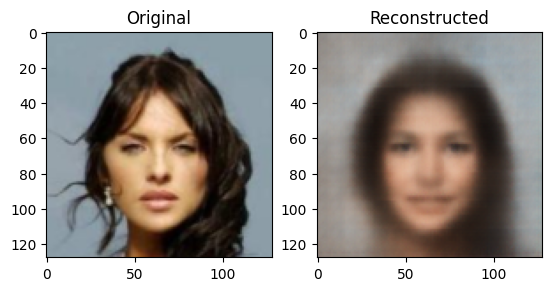

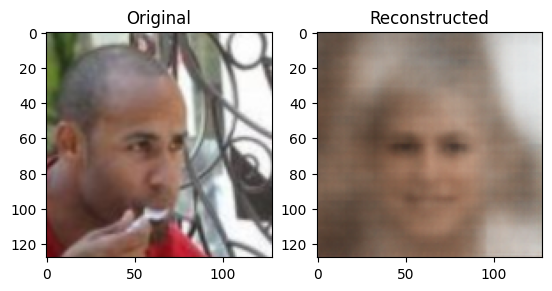

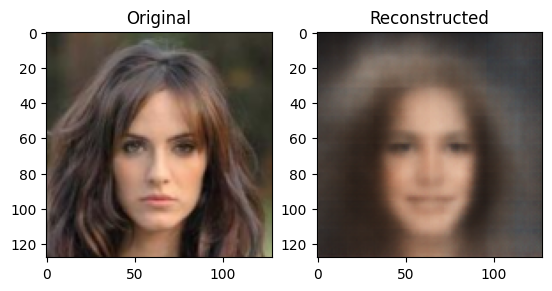

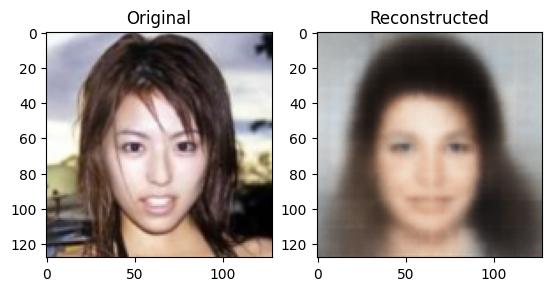

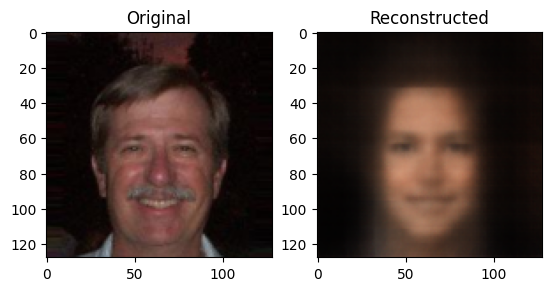

In [4]:
import torch
from torch import nn
from torch.nn import functional as F
from typing import List, TypeVar, Dict, Tuple
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import transforms
from PIL import Image

# CelebAデータセットのカスタムデータセットクラス
class CelebADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.dataset = ImageFolder(root=root_dir, transform=transform)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx][0]

# VAEモデルの定義
class VAE_CelebA(nn.Module):
    def __init__(self, in_channels: int, latent_dim: int, hidden_dims: List = None):
        super(VAE_CelebA, self).__init__()
        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # エンコーダーの構築
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)

        # エンコーダーの出力サイズを計算
        self.feature_size = self._get_feature_size()

        # エンコーダーの出力サイズに基づいて全結合層を定義
        self.fc_mu = nn.Linear(self.feature_size, latent_dim)
        self.fc_var = nn.Linear(self.feature_size, latent_dim)

        # デコーダーの構築
        modules = []
        self.decoder_input = nn.Linear(latent_dim, self.feature_size)
        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride=2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(hidden_dims[-1],
                               hidden_dims[-1],
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
            nn.BatchNorm2d(hidden_dims[-1]),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_dims[-1], out_channels=3,
                      kernel_size=3, padding=1),
            nn.Tanh())

    def _get_feature_size(self):
        x = torch.zeros(1, 3, 128, 128)
        x = self.encoder(x)
        return x.view(1, -1).size(1)

    def encode(self, input: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)
        return mu, log_var

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        result = self.decoder_input(z)
        result = result.view(-1, 512, 4, 4)
        result = self.decoder(result)
        result = self.final_layer(result)
        result = (result + 1.) / 2.
        return result

    def forward(self, input: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), input, mu, log_var

    def loss_function(self,
                      recons: torch.Tensor, 
                      input: torch.Tensor, 
                      mu: torch.Tensor, 
                      log_var: torch.Tensor, 
                      kld_weight: float = 0.00025) -> torch.Tensor:
        recons_loss = F.mse_loss(recons, input)
        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim=1), dim=0)
        loss = recons_loss + kld_weight * kld_loss
        return loss

# データ変換の定義
IMAGE_SIZE = 128
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE, antialias=True),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor()
])

# データセットとデータローダの作成
data_dir = '/home/data/hnakai/CelebA'
dataset = CelebADataset(root_dir=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)

# モデル、オプティマイザ、ロス関数の設定
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = VAE_CelebA(in_channels=3, latent_dim=128).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# トレーニングループ
num_epochs = 10
model.train()
for epoch in range(num_epochs):
    for batch_idx, images in enumerate(dataloader):
        images = images.to(device)
        optimizer.zero_grad()
        recons, input, mu, log_var = model(images)
        loss = model.loss_function(recons, input, mu, log_var)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch}/{num_epochs}] Batch [{batch_idx}/{len(dataloader)}] Loss: {loss.item():.4f}')

# トレーニング終了後、モデルを保存
torch.save(model.state_dict(), 'vae_celeba.pth')

# モデルのテストと入力画像の再構成
model.eval()
with torch.no_grad():
    for batch_idx, images in enumerate(dataloader):
        if batch_idx == 0:  # 最初のバッチだけ使用
            images = images.to(device)
            recons, _, _, _ = model(images)
            break

    # 再構成された画像と元の画像を表示
    for i in range(5):
        original = transforms.ToPILImage()(images[i].cpu())
        reconstructed = transforms.ToPILImage()(recons[i].cpu())

        fig, axes = plt.subplots(1, 2)
        axes[0].imshow(original)
        axes[0].set_title("Original")
        axes[1].imshow(reconstructed)
        axes[1].set_title("Reconstructed")
        plt.show()
